In [1]:
from luma.core.interface.serial import i2c
from luma.core.render import canvas
from luma.oled.device import ssd1309
import time
import random

import numpy as np
import tensorflow as tf
import picamera
import picamera.array
from time import sleep
from io import BytesIO
from PIL import Image
from matplotlib import pyplot as plt
from matplotlib import patches

In [2]:
serial = i2c(port=1, address=0x3c)

In [3]:
serial

In [4]:
device = ssd1309(serial, rotate=1)

In [5]:
device.bounding_box

(0, 0, 63, 127)

In [6]:
with canvas(device) as draw:
    draw.rectangle((5,1,10,20), outline = "white")
    draw.text((7,5), "Hello world", fill = "white")
time.sleep(5)

In [169]:
x,y = 0,0
width, height= 5,5

for _ in range(100):
    with canvas(device) as draw:
        draw.rectangle((x,y,x+width,y+height), outline = "white")
    if random.randint(0,10) >3:
        x += 1
    else:
        x -= 1
    if random.randint(0,10)>3:
        y += 1
    else:
        y -= 1
    if random.randint(0,10)>3:
        width += 2
    else:
        width -= 2
    if random.randint(0,10) >3:
        height += 1
    else:
        height -=1
    time.sleep(.1)
    

## TFlite section

In [36]:
# from https://hub.tensorflow.google.cn/tensorflow/lite-model/ssd_mobilenet_v1/1/default/1
interpreter = tf.lite.Interpreter(model_path="./models/ssd_mobilenet_v1_1_default_1.tflite")
interpreter.allocate_tensors()

In [37]:
input_details = interpreter.get_input_details()
input_details

[{'name': 'normalized_input_image_tensor',
  'index': 175,
  'shape': array([  1, 300, 300,   3]),
  'dtype': numpy.uint8,
  'quantization': (0.0078125, 128)}]

In [38]:
output_details = interpreter.get_output_details()
output_details

[{'name': 'TFLite_Detection_PostProcess',
  'index': 167,
  'shape': array([ 1, 10,  4]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0)},
 {'name': 'TFLite_Detection_PostProcess:1',
  'index': 168,
  'shape': array([ 1, 10]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0)},
 {'name': 'TFLite_Detection_PostProcess:2',
  'index': 169,
  'shape': array([ 1, 10]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0)},
 {'name': 'TFLite_Detection_PostProcess:3',
  'index': 170,
  'shape': array([1]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0)}]

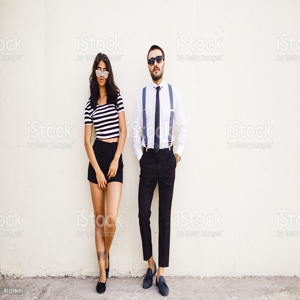

In [10]:
test_image = Image.open("./istockphoto-611216474-1024x1024.jpg")
test_image.resize((300,300))

In [115]:
np.array(test_image.resize((320,320)), dtype=np.float32).reshape(1,300,300,3)

array([[[[ 89., 101.,  15.],
         [ 84.,  94.,  21.],
         [ 89., 100.,  21.],
         ...,
         [ 72.,  67.,  38.],
         [ 76.,  69.,  41.],
         [ 79.,  68.,  46.]],

        [[ 96., 106.,   9.],
         [112., 121.,  28.],
         [130., 141.,  37.],
         ...,
         [ 92.,  81.,  51.],
         [103.,  90.,  58.],
         [ 95.,  79.,  53.]],

        [[117., 125.,  16.],
         [139., 147.,  38.],
         [150., 160.,  37.],
         ...,
         [107.,  92.,  59.],
         [117., 101.,  67.],
         [109.,  90.,  60.]],

        ...,

        [[ 82.,  90.,  93.],
         [ 85.,  93.,  96.],
         [ 85.,  93.,  96.],
         ...,
         [135., 155., 180.],
         [136., 156., 181.],
         [138., 158., 183.]],

        [[ 80.,  88.,  91.],
         [ 83.,  91.,  94.],
         [ 84.,  92.,  95.],
         ...,
         [129., 149., 174.],
         [130., 150., 175.],
         [132., 152., 177.]],

        [[ 80.,  88.,  91.],
       

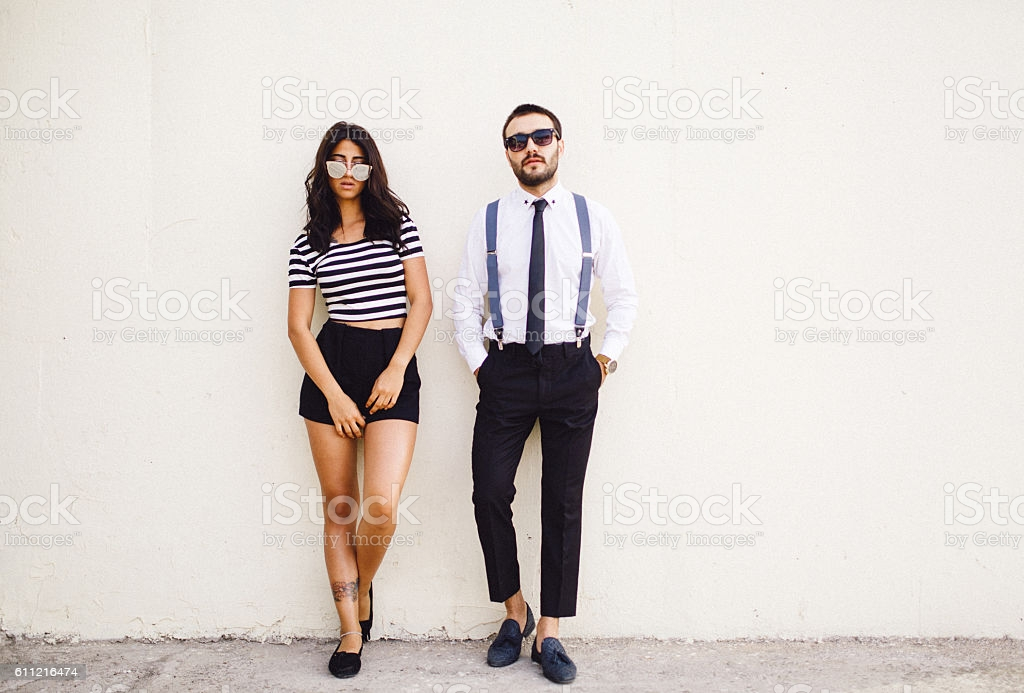

In [172]:
test_image

In [171]:
test_image.size

(1024, 693)

In [178]:
test_image = test_image.crop((test_image.size[0]/4,
                0,
                test_image.size[0]/4*3,
                test_image.size[1]))

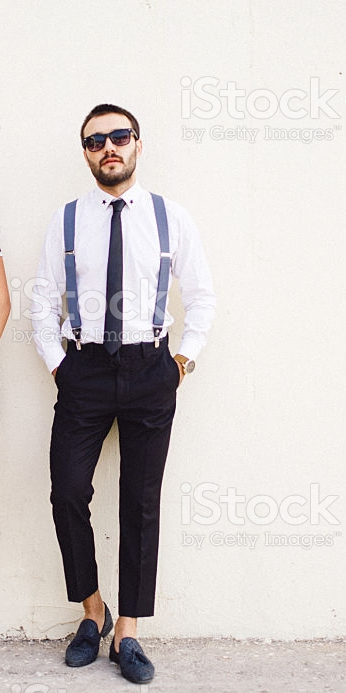

In [180]:
chopped_image = test_image.crop((test_image.size[0]-test_image.size[1]/2,
                0,
                test_image.size[0],
                test_image.size[1]))
chopped_image

In [184]:
chopped_image.size

(346, 693)

In [191]:
interpreter.set_tensor(input_details[0]['index'], np.array(chopped_image.resize((300,300)), dtype=np.uint8).reshape(1,300,300,3))

In [192]:
interpreter.invoke()

[0.11067691 0.07898504 1.0087514  0.59547603]
0.0
	(23.69551, 302.62543) 154.9473 -269.42236


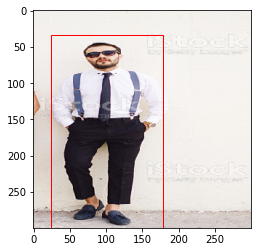

In [195]:
fig, ax = plt.subplots(1)
output_bbs = interpreter.get_tensor(output_details[0]['index'])
output_classes = interpreter.get_tensor(output_details[1]['index'])
output_probs = interpreter.get_tensor(output_details[2]['index'])

#plt.imshow(rnd_input_data.reshape((300,300,3)))
plt.imshow(np.array(chopped_image.resize((300,300))))
for i in range(0, min(10,len(output_bbs[0]))):
    if output_probs[0][i] < .5 or output_classes[0][i] != 0.0:
        continue
    detection = output_bbs[0][i]
    print(detection)
    print(output_classes[0][i])
    top_rect = detection*300
    #print(str(i) + ": " + model_classes[int(output_classes[0][i])] + str(top_rect))
    #print("bottom left:" + str((top_rect[2], top_rect[3])))
    #print("width:" + str(top_rect[3]-top_rect[1]))
    #print("width:" + str(top_rect[2]-top_rect[0]))
    xy = (top_rect[1], top_rect[2])
    width = top_rect[3]-top_rect[1]
    height = top_rect[0]-top_rect[2]
    print("\t" + str(xy) + " " + str(width) + " " + str(height))
    rect = patches.Rectangle(xy, width, height, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    #text = model_classes[int(output_classes[0][i])]
    #ax.text(top_rect[1], top_rect[0], str(i) + ": " + text)

[0.11067691 0.07898504 1.0087514  0.59547603]
	(27.328823, 699.0647) 178.70589 -622.3656


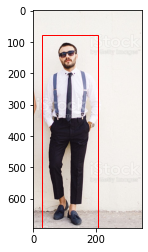

In [199]:
fig, ax = plt.subplots(1)
output_bbs = interpreter.get_tensor(output_details[0]['index'])
output_classes = interpreter.get_tensor(output_details[1]['index'])
output_probs = interpreter.get_tensor(output_details[2]['index'])

#plt.imshow(rnd_input_data.reshape((300,300,3)))
#plt.imshow(np.array(chopped_image.resize((300,300))))
plt.imshow(np.array(chopped_image))

for i in range(0, min(10,len(output_bbs[0]))):
    if output_probs[0][i] < .5 or output_classes[0][i] != 0.0:
        continue
    detection = output_bbs[0][i]
    print(detection)
    #print(output_classes[0][i])
    top_rect = detection
    detection[0] = detection[0]*chopped_image.size[1]
    detection[1] = detection[1]*chopped_image.size[0]
    detection[2] = detection[2]*chopped_image.size[1]
    detection[3] = detection[3]*chopped_image.size[0]
    #top_rect = [0,0,0,0]
    #O = h*o
    #top_rect[0] = chopped_image.size[1]*detection[3]
    #L
    #top_rect[1] = chopped_image.size[0]*detection[0]
    #U
    #top_rect[2] = chopped_image.size[1]*detection[1]
    #R
    #top_rect[3] = chopped_image.size[0]*detection[2]
    #print(str(i) + ": " + model_classes[int(output_classes[0][i])] + str(top_rect))
    #print("bottom left:" + str((top_rect[2], top_rect[3])))
    #print("width:" + str(top_rect[3]-top_rect[1]))
    #print("width:" + str(top_rect[2]-top_rect[0]))
    #print(top_rect)
    xy = (top_rect[1], top_rect[2])
    width = top_rect[3]-top_rect[1]
    height = top_rect[0]-top_rect[2]
    print("\t" + str(xy) + " " + str(width) + " " + str(height))
    rect = patches.Rectangle(xy, width, height, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    #text = model_classes[int(output_classes[0][i])]
    #ax.text(top_rect[1], top_rect[0], str(i) + ": " + text)

[0.11067691 0.07898504 1.0087514  0.59547603]
[ 76.699104  27.328823 699.0647   206.03471 ]
	(27.328823, 699.0647) 178.7058868408203 -622.3656005859375
(5.055042266845703, 14.166645050048828, 33.055423736572266, 114.95353698730469)


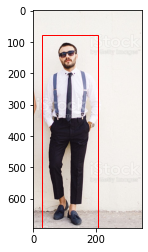

In [219]:
fig, ax = plt.subplots(1)
output_bbs = interpreter.get_tensor(output_details[0]['index'])
output_classes = interpreter.get_tensor(output_details[1]['index'])
output_probs = interpreter.get_tensor(output_details[2]['index'])

#plt.imshow(rnd_input_data.reshape((300,300,3)))
#plt.imshow(np.array(chopped_image.resize((300,300))))
plt.imshow(np.array(chopped_image))

for i in range(0, min(10,len(output_bbs[0]))):
    if output_probs[0][i] < .5 or output_classes[0][i] != 0.0:
        continue
    detection = output_bbs[0][i]
    print(detection)
    screen_coords = (detection[1]*64.0,
                     detection[0]*128.0,  
                    (detection[3]-detection[1])*64.0,
                    (detection[2]-detection[0])*128.0)
    #print(output_classes[0][i])
    top_rect = detection
    #top
    top_rect[0] = detection[0]*chopped_image.size[1]
    #left
    top_rect[1] = detection[1]*chopped_image.size[0]
    #bottom
    top_rect[2] = detection[2]*chopped_image.size[1]
    #right
    top_rect[3] = detection[3]*chopped_image.size[0]
    print(detection)
    xy = (top_rect[1], top_rect[2])
    width = -1*(top_rect[1]-top_rect[3])
    height = -1*(top_rect[2]-top_rect[0])
    print("\t" + str(xy) + " " + str(width) + " " + str(height))
    print(screen_coords)
    rect = patches.Rectangle(xy, width, height, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    with canvas(device) as draw:
        draw.rectangle(screen_coords, outline = "white")

    #text = model_classes[int(output_classes[0][i])]
    #ax.text(top_rect[1], top_rect[0], str(i) + ": " + text)

In [34]:
def detect_and_scout(image, interpreter):
    chopped_image = image.crop((image.size[0]-image.size[1]/2,
                0,
                image.size[0],
                image.size[1]))
    interpreter.set_tensor(input_details[0]['index'], np.array(chopped_image.resize((300,300)), dtype=np.uint8).reshape(1,300,300,3))
    interpreter.invoke()
    
    output_bbs = interpreter.get_tensor(output_details[0]['index'])
    output_classes = interpreter.get_tensor(output_details[1]['index'])
    output_probs = interpreter.get_tensor(output_details[2]['index'])
    with canvas(device) as draw:
        for i in range(0, min(10,len(output_bbs[0]))):
            if output_probs[0][i] < .5 or output_classes[0][i] != 0.0:
                continue
            detection = output_bbs[0][i]
            #print(detection)
            screen_coords = (detection[1]*64.0,
                             detection[0]*128.0,  
                             detection[3]*64.0,
                             detection[2]*128.0)
            #print(detection)
            draw.rectangle(screen_coords, outline = "white")

In [12]:
def detect_and_render(image, interpreter):
    chopped_image = image.crop((image.size[0]-image.size[1]/2,
                0,
                image.size[0],
                image.size[1]))
    interpreter.set_tensor(input_details[0]['index'], np.array(chopped_image.resize((300,300)), dtype=np.uint8).reshape(1,300,300,3))
    interpreter.invoke()

    fig, ax = plt.subplots(1)
    output_bbs = interpreter.get_tensor(output_details[0]['index'])
    output_classes = interpreter.get_tensor(output_details[1]['index'])
    output_probs = interpreter.get_tensor(output_details[2]['index'])

    #plt.imshow(rnd_input_data.reshape((300,300,3)))
    #plt.imshow(np.array(chopped_image.resize((300,300))))
    plt.imshow(np.array(chopped_image))

    for i in range(0, min(10,len(output_bbs[0]))):
        if output_probs[0][i] < .5 or output_classes[0][i] != 0.0:
            continue
        detection = output_bbs[0][i]
        print("top, left, bottom, right")
        print(detection)
        screen_coords = (detection[1]*64.0,
                         detection[0]*128.0,  
                        (detection[3]-detection[1])*64.0,
                        (detection[2]-detection[0])*128.0)
        print(screen_coords)
        #print(output_classes[0][i])
        top_rect = detection
        #top
        top_rect[0] = detection[0]*chopped_image.size[1]
        #left
        top_rect[1] = detection[1]*chopped_image.size[0]
        #bottom
        top_rect[2] = detection[2]*chopped_image.size[1]
        #right
        top_rect[3] = detection[3]*chopped_image.size[0]
        print(detection)
        xy = (top_rect[1], top_rect[2])
        width = -1*(top_rect[1]-top_rect[3])
        height = -1*(top_rect[2]-top_rect[0])
        print("\t" + str(xy) + " " + str(width) + " " + str(height))
        rect = patches.Rectangle(xy, width, height, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        print("")

        #text = model_classes[int(output_classes[0][i])]
        #ax.text(top_rect[1], top_rect[0], str(i) + ": " + text)

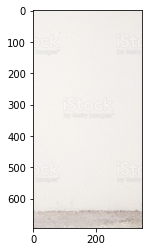

In [13]:
detect_and_render(test_image, interpreter)

In [265]:
detect_and_scout(test_image, interpreter)

[0.11067691 0.07898504 1.0087514  0.59547603]


top, left, bottom, right
[0.11715975 0.00138885 0.9908452  0.5626376 ]
(0.08888626098632812, 14.996448516845703, 35.919921875, 111.83174133300781)
[9.3727806e+01 5.5553913e-01 7.9267615e+02 2.2505505e+02]
	(0.55553913, 792.67615) 224.49951171875 -698.9483642578125

top, left, bottom, right
[0.20151922 0.4727321  0.9743086  0.9974514 ]
(30.254854202270508, 25.79446029663086, 33.58203887939453, 98.91703796386719)
[161.21538 189.09283 779.4469  398.98056]
	(189.09283, 779.4469) 209.88772583007812 -618.2315063476562



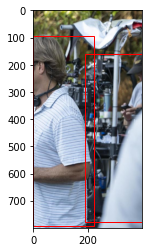

In [14]:
detect_and_render(Image.open("./5e984ef94b262.image.jpg"), interpreter)

In [15]:
detect_and_scout(Image.open("./5e984ef94b262.image.jpg"), interpreter)

[0.11715975 0.00138885 0.9908452  0.5626376 ]
[0.20151922 0.4727321  0.9743086  0.9974514 ]


In [150]:
output_classes = interpreter.get_tensor(output_details[1]['index'])
output_classes

array([[ 0.,  0., 31., 31., 31., 31., 31.,  0.,  0.,  0.]], dtype=float32)

In [159]:
output_probs

array([[0.78515625, 0.77734375, 0.48828125, 0.4375    , 0.390625  ,
        0.37890625, 0.35546875, 0.33203125, 0.30078125, 0.2890625 ]],
      dtype=float32)

In [170]:
output_bbs[0]

array([[0.14540297, 0.4482829 , 0.9516173 , 0.5918245 ],
       [0.17089912, 0.28425336, 0.964471  , 0.4190008 ],
       [0.3064225 , 0.53123766, 0.47473124, 0.5542101 ],
       [0.2940457 , 0.47680527, 0.47333884, 0.5016669 ],
       [0.3572219 , 0.5315408 , 0.4858731 , 0.55084723],
       [0.34472686, 0.48380825, 0.49071854, 0.5053733 ],
       [0.2904597 , 0.53205585, 0.38132536, 0.54880226],
       [0.15030237, 0.47458518, 0.53369135, 0.60168314],
       [0.15794632, 0.39749542, 0.9390739 , 0.53438956],
       [0.19245239, 0.2832913 , 0.6486433 , 0.4186841 ]], dtype=float32)

In [16]:
camera = picamera.PiCamera()
camera.resolution=(1024,768)

In [ ]:
camera.capture("../data/foo.jpg")

In [17]:

my_stream = BytesIO()

In [18]:

camera.capture(my_stream, "jpeg", resize=(300,300))

In [19]:
my_stream.seek(0)

0

In [20]:

image = Image.open(my_stream)

In [ ]:
my_stream.truncate(0)

top, left, bottom, right
[0.4575592  0.01735824 0.99913037 0.59427434]
(1.1109275817871094, 58.56757736206055, 36.922630310058594, 69.32110595703125)
[137.26776     2.6037364 299.7391     89.14115  ]
	(2.6037364, 299.7391) 86.53741455078125 -162.47134399414062

top, left, bottom, right
[0.44162077 0.00251037 1.0132625  0.91884494]
(0.16066360473632812, 56.52745819091797, 58.64541244506836, 73.1701431274414)
[132.48624      0.37655532 303.97876    137.82674   ]
	(0.37655532, 303.97876) 137.45018005371094 -171.49252319335938

top, left, bottom, right
[ 0.45986626 -0.01613422  1.0173548   0.35938245]
(-1.0325899124145508, 58.86288070678711, 24.033065795898438, 71.35853576660156)
[137.95987    -2.4201326 305.20645    53.907368 ]
	(-2.4201326, 305.20645) 56.32749938964844 -167.24658203125



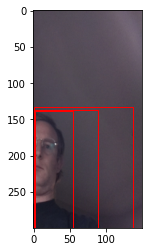

In [21]:
detect_and_render(image, interpreter)

In [22]:
def capture_detect_render(camera, interpreter):
    my_stream = BytesIO()
    camera.capture(my_stream, "jpeg", resize=(300,300))
    my_stream.seek(0)
    detect_and_render(Image.open(my_stream), interpreter)

In [23]:
def capture_detect_scout(camera, interpreter):
    my_stream = BytesIO()
    camera.capture(my_stream, "jpeg", resize=(300,300))
    my_stream.seek(0)
    detect_and_scout(Image.open(my_stream), interpreter)

top, left, bottom, right
[0.41970718 0.00962266 0.9966233  0.83284724]
(0.6158504486083984, 53.72251892089844, 52.686370849609375, 73.84526062011719)
[125.912155    1.4433994 298.98697   124.927086 ]
	(1.4433994, 298.98697) 123.48368835449219 -173.07481384277344



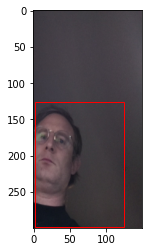

In [29]:
capture_detect_render(camera, interpreter)

In [39]:
for _ in range(0,100):
    capture_detect_scout(camera, interpreter)

KeyboardInterrupt: 